# Data Science do Zero - Visão Computacional e Deep Learning

#### Importando as bibliotecas necessárias

In [1]:
pip install keras-facenet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from mtcnn.mtcnn import MTCNN

%matplotlib inline

Using TensorFlow backend.


In [3]:
image_size = 160

#### Carregando as imagens de treino e teste

In [4]:
def carrega_imagens(dir_basepath):
    imgs = []
    names = os.listdir(dir_basepath)

    for name in names:
        image_full_path = dir_basepath + name
        for f in os.listdir(image_full_path):
            imgs.append(os.path.join(image_full_path, f))
    return imgs

In [6]:
imgs_train = carrega_imagens('lfw-mini/train/')

In [7]:
imgs_test = carrega_imagens('lfw-mini/test/')

#### Verificando as imagens

In [8]:
for train, test in zip(imgs_train,imgs_test):
    print("{} ------- {}".format(train,test))

lfw-mini/train/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg ------- lfw-mini/test/Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg
lfw-mini/train/Adam_Sandler/Adam_Sandler_0001.jpg ------- lfw-mini/test/Adam_Sandler/Adam_Sandler_0002.jpg
lfw-mini/train/Aaron_Peirsol/Aaron_Peirsol_0001.jpg ------- lfw-mini/test/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-mini/train/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg ------- lfw-mini/test/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg
lfw-mini/train/Adrian_McPherson/Adrian_McPherson_0001.jpg ------- lfw-mini/test/Adrian_McPherson/Adrian_McPherson_0002.jpg
lfw-mini/train/Aitor_Gonzalez/Aitor_Gonzalez_0001.jpg ------- lfw-mini/test/Aitor_Gonzalez/Aitor_Gonzalez_0002.jpg
lfw-mini/train/Abdullah/Abdullah_0001.jpg ------- lfw-mini/test/Abdullah/Abdullah_0002.jpg
lfw-mini/train/Ahmad_Masood/Ahmad_Masood_0001.jpg ------- lfw-mini/test/Ahmad_Masood/Ahmad_Masood_0002.jpg
lfw-mini/train/Ahmed_Chalabi/Ahmed_Chalabi_0001.jpg ------- 

#### Carregando o modelo do Facenet

In [9]:
model_path = 'model/facenet_keras.h5'
model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/felipe/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Carregando o modelo MTCNN para detecção de faces

In [10]:
detector = MTCNN()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


#### Funções para detecção de face, resize e calculo de embeddings

In [12]:
def carrega_alinha_imagens(filepath):
    img = imread(filepath)
    faces = detector.detect_faces(img)

    (x, y, w, h) = faces[0]['box']
    img = img[y:y+h,x:x+w,:]
    img_alinhada = [resize(img, (image_size, image_size), mode='reflect')]
    
    img_alinhada = np.array(img_alinhada)
    
    return img_alinhada

In [13]:
def calcula_embedding(filepath, batch_size=1):
    img_alinhada = carrega_alinha_imagens(filepath)    
    emb = model.predict_on_batch(img_alinhada[0:1])
    return emb

#### Calculando os embeddings para as imagens de treinamento.

In [14]:
labels_train = []
embs_train = []
for image_filepath in (imgs_train):
    labels_train.append(image_filepath.split('/')[-1].replace('.jpg',''))
    embs_train.append(calcula_embedding(image_filepath))

/home/felipe/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [15]:
embs_train = np.concatenate(embs_train)

In [16]:
labels_train = np.array(labels_train)

#### Verificando os shapes.

In [17]:
embs_train.shape

(24, 128)

In [18]:
labels_train.shape

(24,)

#### Calculando os embeddings para as imagens de teste.

In [19]:
labels_test = []
embs_test = []
for image_filepath in (imgs_test):
    labels_test.append(image_filepath.split('/')[-1].replace('.jpg',''))
    embs_test.append(calcula_embedding(image_filepath))

In [20]:
embs_test = np.concatenate(embs_test)

In [21]:
labels_test = np.array(labels_test)

#### Verificando os shapes.

In [22]:
embs_test.shape

(24, 128)

In [23]:
labels_test.shape

(24,)

#### Preparando os dados para rodar o algoritmo de Machine Learning.

##### Aplicando a Normalização nos dados

In [24]:
normalize = Normalizer(norm='l2')
embs_train = normalize.transform(embs_train)
embs_test = normalize.transform(embs_test)

##### Aplicando o Label Encoder para gerar as classes de treino.

In [26]:
le = LabelEncoder().fit(labels_train)

In [27]:
y_train = le.transform(labels_train)

##### Aplicando o Label Encoder para gerar as classes de teste.

In [29]:
le = LabelEncoder().fit(labels_test)

In [30]:
y_test = le.transform(labels_test)

#### Treinando o Classificador SVM.

In [31]:
clf_svm = SVC()

In [32]:
clf_svm.fit(embs_train, y_train)

/home/felipe/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Avaliando os resultados.

In [33]:
y_pred = clf_svm.predict(embs_test)

In [35]:
accuracy_score(y_test, y_pred)

0.8333333333333334

#### Verificando os resultados de forma visual.

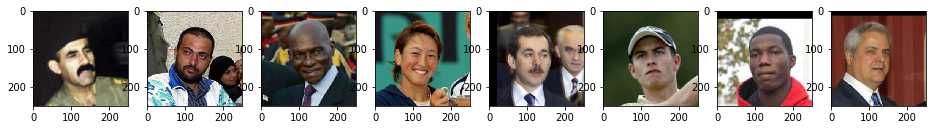

In [36]:
fig, axes = plt.subplots(1,8, figsize=(16, 16))

i = 0

for index in y_test[:8]:
    img = imgs_test[index]
    img = imread(img)
    axes[i].imshow(img)
    i+=1

plt.show()

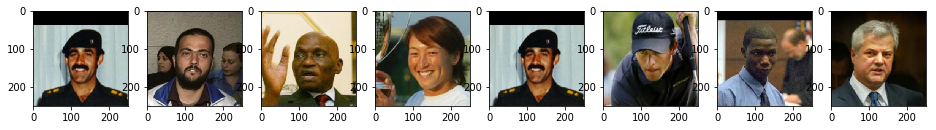

In [37]:
fig, axes = plt.subplots(1,8, figsize=(16, 16))

i = 0

for index in y_pred[:8]:
    img = imgs_train[index]
    img = imread(img)
    axes[i].imshow(img)
    i+=1

plt.show()